In [1]:
# Verify Spark works
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("SmartSales").getOrCreate()
print(spark)

25/04/06 23:43:07 WARN Utils: Your hostname, Kyles-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.14 instead (on interface en0)
25/04/06 23:43:07 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/06 23:43:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("SmartSales") \
    .config("spark.jars", "/Users/kyleroof/Projects/smart-store-kyleroof/drivers/sqlite-jdbc-3.49.1.0.jar") \
    .config("spark.driver.extraClassPath", "/Users/kyleroof/Projects/smart-store-kyleroof/drivers/sqlite-jdbc-3.49.1.0.jar") \
    .getOrCreate()

df_sales = spark.read.format("jdbc") \
    .option("url", "jdbc:sqlite:/Users/kyleroof/Projects/smart-store-kyleroof/data/dw/smart_sales.db") \
    .option("dbtable", "sale") \
    .option("driver", "org.sqlite.JDBC") \
    .load()

df_sales.show()

25/04/07 00:20:54 WARN Utils: Your hostname, Kyles-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.14 instead (on interface en0)
25/04/07 00:20:54 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/04/07 00:20:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


+-------+-----------+----------+-----------+----------+--------+-----------+----------------+------------+
|sale_id|customer_id|product_id|sale_amount| sale_date|store_id|campaign_id|discount_percent|payment_type|
+-------+-----------+----------+-----------+----------+--------+-----------+----------------+------------+
|    551|       1009|       105|      19.78|2024-01-06|     403|          0|              15|       debit|
|    552|       1004|       107|      335.1|2024-01-16|     404|          0|               0|      credit|
|    553|       1006|       102|      195.5|2024-01-16|     406|          0|               0|      credit|
|    554|       1005|       102|      117.3|2024-01-25|     405|          0|               0|      credit|
|    555|       1001|       101|    2379.36|2024-01-25|     401|          0|              10|      credit|
|    556|       1009|       104|      172.4|2024-01-29|     403|          0|               0|      credit|
|    557|       1010|       101|    3

In [2]:
df_sales = spark.read.format("jdbc") \
    .option("url", "jdbc:sqlite:/Users/kyleroof/Projects/smart-store-kyleroof/data/dw/smart_sales.db") \
    .option("dbtable", "sale") \
    .option("driver", "org.sqlite.JDBC") \
    .load()

df_customers = spark.read.format("jdbc") \
    .option("url", "jdbc:sqlite:/Users/kyleroof/Projects/smart-store-kyleroof/data/dw/smart_sales.db") \
    .option("dbtable", "customer") \
    .option("driver", "org.sqlite.JDBC") \
    .load()

In [3]:
df_sales.createOrReplaceTempView("sale")
df_customers.createOrReplaceTempView("customer")

In [4]:
df_top_customers = spark.sql("""
SELECT c.name, SUM(s.sale_amount) AS total_spent
FROM sale s
JOIN customer c ON s.customer_id = c.customer_id
GROUP BY c.name
ORDER BY total_spent DESC
""")

In [5]:
df_top_customers.show()

+----------------+------------------+
|            name|       total_spent|
+----------------+------------------+
|   William White|23752.520000000004|
|Hermione Granger|          22822.54|
|   Susan Johnson|           12344.4|
|       Chewbacca|11813.439999999999|
|   Tiffany James|          11715.82|
|    Wylie Coyote|           7434.44|
|          Dr Who|4064.8599999999997|
|       Dan Brown|2427.2999999999997|
|    Jason Bourne|           1806.34|
|      Tony Stark|           1506.44|
+----------------+------------------+



In [6]:
import pandas as pd

df_top_customers_pd = df_top_customers.toPandas()

In [7]:
from pyspark.sql.functions import col, to_date

# Ensure sale_date is in date format
df_sales = df_sales.withColumn("sale_date", to_date(col("sale_date"), "yyyy-MM-dd"))

# Filter sales after 2023-01-01
df_filtered = df_sales.filter(col("sale_date") >= "2023-01-01")
df_filtered.show()

+-------+-----------+----------+-----------+----------+--------+-----------+----------------+------------+
|sale_id|customer_id|product_id|sale_amount| sale_date|store_id|campaign_id|discount_percent|payment_type|
+-------+-----------+----------+-----------+----------+--------+-----------+----------------+------------+
|    551|       1009|       105|      19.78|2024-01-06|     403|          0|              15|       debit|
|    552|       1004|       107|      335.1|2024-01-16|     404|          0|               0|      credit|
|    553|       1006|       102|      195.5|2024-01-16|     406|          0|               0|      credit|
|    554|       1005|       102|      117.3|2024-01-25|     405|          0|               0|      credit|
|    555|       1001|       101|    2379.36|2024-01-25|     401|          0|              10|      credit|
|    556|       1009|       104|      172.4|2024-01-29|     403|          0|               0|      credit|
|    557|       1010|       101|    3

In [8]:
df_products = spark.read.format("jdbc") \
    .option("url", "jdbc:sqlite:/Users/kyleroof/Projects/smart-store-kyleroof/data/dw/smart_sales.db") \
    .option("dbtable", "product") \
    .option("driver", "org.sqlite.JDBC") \
    .load()

In [9]:
# Join with product and customer data
df_combined = df_sales \
    .join(df_products, on="product_id") \
    .join(df_customers, on="customer_id")

# Group and summarize
df_combined.groupBy("category", "region").sum("sale_amount").show()

+-----------+------+------------------+
|   category|region|  sum(sale_amount)|
+-----------+------+------------------+
|     Sports| North|            336.26|
|   Clothing|  West|           2370.78|
|   Clothing| North|           3544.42|
|     Sports|  West|             19.78|
|Electronics| North|1690.6200000000001|
|   Clothing| South|3309.1400000000003|
|     Sports| South|             39.56|
|   Clothing|  East|            3279.0|
|Electronics|  East|          50552.48|
|     Sports|  East|            178.02|
|Electronics| South|20711.520000000004|
|Electronics|  West|          13656.52|
+-----------+------+------------------+



In [10]:
from pyspark.sql.functions import year, quarter, month

df_sales_drill = df_sales.withColumn("year", year("sale_date")) \
    .withColumn("quarter", quarter("sale_date")) \
    .withColumn("month", month("sale_date"))

df_sales_drill.groupBy("year", "quarter", "month").sum("sale_amount").show()

+----+-------+-----+------------------+
|year|quarter|month|  sum(sale_amount)|
+----+-------+-----+------------------+
|2024|      1|    1|           6391.92|
|2024|      3|    9| 9492.800000000001|
|2024|      3|    7|21038.120000000003|
|2024|      3|    8| 4627.200000000001|
|2024|      1|    3|          12150.18|
|2024|      2|    6| 6444.100000000001|
|2024|      1|    2|14591.460000000001|
|2024|      2|    5|          10982.82|
|2024|      2|    4|           16866.9|
|2024|      4|   10|           5853.54|
+----+-------+-----+------------------+



Matplotlib is building the font cache; this may take a moment.


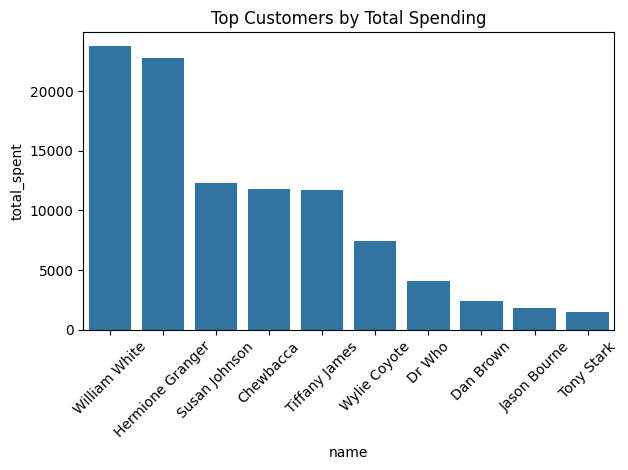

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(data=df_top_customers_pd, x="name", y="total_spent")
plt.xticks(rotation=45)
plt.title("Top Customers by Total Spending")
plt.tight_layout()
plt.show()

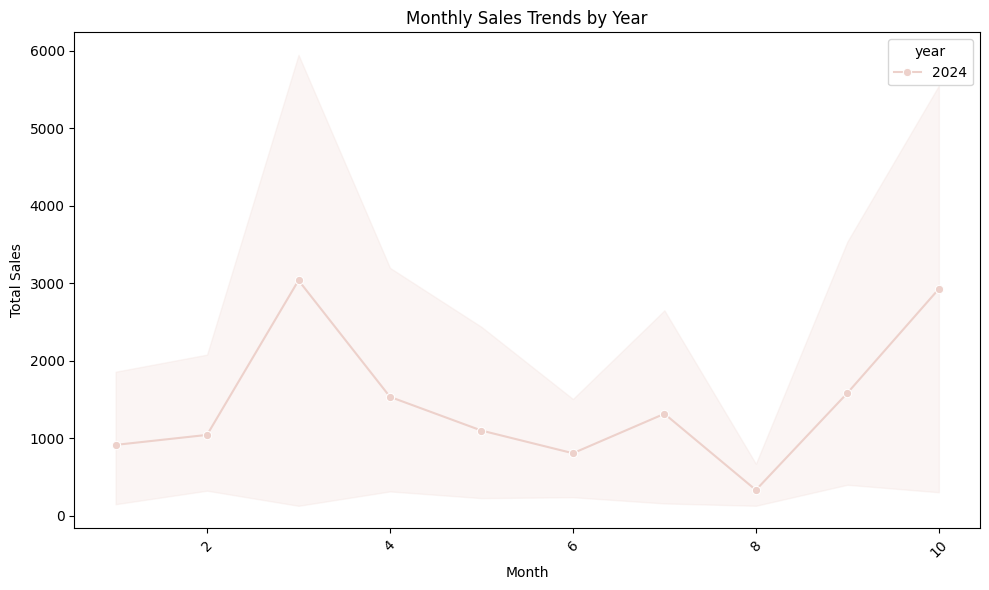

In [12]:
df_sales_drill_pd = df_sales_drill.toPandas()

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_sales_drill_pd, x="month", y="sale_amount", hue="year", marker="o")
plt.title("Monthly Sales Trends by Year")
plt.ylabel("Total Sales")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()